In [7]:
import glob
import numpy as np
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os
from scipy.spatial import distance
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from scipy import special, optimize
from scipy.interpolate import InterpolatedUnivariateSpline
import sys

# add cwd to path when script run by slurm
sys.path.append(os.getcwd())

a = 3
n_spheres=1
color_list = []
for color in colors.cnames:
    color_list.append(color)

In [8]:
# ### 0.2 define helper functions
# 2)preprocess df_time, df_pnode, df_pcenter
def preprocess_dataframe(df_time,df_pcenter,df_pnode):

    return num_of_particles, num_of_nodes, num_of_steps

In [11]:
# ### 1.  Analyze data
# **1. process dataframe**
datapath = os.getcwd()
timefile = "out.time"
pcenterfile = "output_particle_trajectory.csv"
pnodefile = "output_surface_node.csv"
print ("analyze timefile: %s"% timefile)
print ("analyze particle center file: %s"%pcenterfile)
print ("analyze surface node file: %s"%pnodefile)
df_time = pd.read_csv(timefile,delimiter=" ",engine='python')
df_time = df_time.dropna(axis=1)
df_time.columns=["step_id","o_step","real_time"]
df_pcenter = pd.read_csv(pcenterfile,delimiter=" ",engine='python',skiprows=1, header=None,comment="#")
df_pcenter = df_pcenter.dropna(axis=1)
df_pcenter.columns=["particle_id","x_coord","y_coord","z_coord","x_vel","y_vel","z_vel","x_force","y_force","z_force"]
df_pnode = pd.read_csv(pnodefile,delimiter=" ",engine='python',skiprows=1, header=None,comment="#")
df_pnode = df_pnode.dropna(axis=1)
df_pnode.columns=["particle_id","node_id","x_coord","y_coord","z_coord","node_center_distance"]
# process dataframe    # compute total number of nodes among all particles
num_of_nodes = 0
for particle_id in df_pnode.particle_id.unique():
    num_of_nodes += df_pnode[df_pnode.particle_id==particle_id].node_id.unique().shape[0]
num_of_particles = df_pnode.particle_id.unique().shape[0]
# add "o_step" column to df_pcenter
df_pcenter["o_step"] = pd.Series(df_pcenter.index.values//num_of_particles,index=df_pcenter.index)
# add "particle_type_id" column to df_pcenter
df_pcenter["particle_type_id"] = pd.Series(df_pcenter["particle_id"].values >= n_spheres, index=df_pcenter.index) * 1
# add "o_step" column to df_node
df_pnode["o_step"] = pd.Series(df_pnode.index.values // num_of_nodes,index=df_pnode.index)
# add "particle_type_id" column to df_pnode
df_pnode["particle_type_id"] = pd.Series(df_pnode["particle_id"].values >= n_spheres, index=df_pnode.index) * 1
# the minimum final o_step
final_o_step = np.min([df_pcenter.o_step.values[-1],df_pnode.o_step.values[-1],df_time.o_step.values[-1]])
print(final_o_step)
df_time = df_time[df_time.o_step<=final_o_step]
df_pcenter = df_pcenter[df_pcenter.o_step<=final_o_step]
df_pnode = df_pnode[df_pnode.o_step<=final_o_step]
num_of_steps=final_o_step
print(df_pnode.tail(1))
print(df_pcenter.tail(1))
print(df_time.tail(1))
# add "real_time" column to df_pnode and df_pcenter
real_time_matrix = df_time.real_time.values
df_pcenter["real_time"]=df_pcenter["o_step"].apply(lambda x: real_time_matrix[x])
df_pnode["real_time"] = df_pnode["o_step"].apply(lambda x: real_time_matrix[x])

analyze timefile: out.time
analyze particle center file: output_particle_trajectory.csv
analyze surface node file: output_surface_node.csv
100
       particle_id  node_id   x_coord  y_coord   z_coord  \
16664            0      164 -0.093785  2.93846  0.595534   

       node_center_distance  o_step  particle_type_id  
16664              3.000978     100                 0  
     particle_id   x_coord   y_coord   z_coord     x_vel     y_vel     z_vel  \
100            0  0.001071 -0.001699  0.001954 -0.000072  0.000003 -0.000024   

      x_force   y_force   z_force  o_step  particle_type_id  
100 -0.011869  0.000508 -0.004026     100                 0  
     step_id  o_step  real_time
100    10000     100       10.0


In [115]:
o_interval = 10
times, w_means, w_stds = [], [], []
for o_id in range(df_pnode["o_step"].max() - o_interval):
    time_s = df_pnode[df_pnode["o_step"]==o_id]["real_time"].iloc[0]
    time_e = df_pnode[df_pnode["o_step"]==(o_id+o_interval)]["real_time"].iloc[0]
    pt_s = df_pnode[df_pnode["o_step"]==o_id][["x_coord", "y_coord", "z_coord"]].values
    pt_e = df_pnode[df_pnode["o_step"]==(o_id+o_interval)][["x_coord", "y_coord", "z_coord"]].values
    r = np.sqrt(a**2 - pt_s[:,2]**2)
    ds = LA.norm(pt_e - pt_s, axis=1)
    dt = time_e - time_s
    w = ds / r /dt
    w_means.append(np.mean(w))
    w_stds.append(np.std(w))
    times.append(time_s)

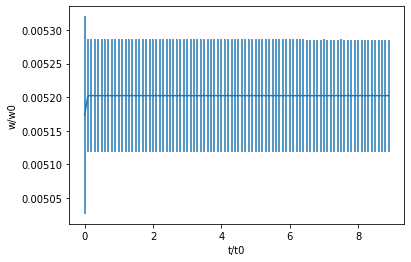

In [117]:
plt.figure()
plt.errorbar(times, w_means, yerr=w_stds)
plt.xlabel("t/t0")
plt.ylabel("w/w0")
# plt.show()
plt.savefig("w.png", dpi=300)